In [9]:
# # Seattle Building Energy Data: Cleaning and EDA with Plotly

# ## Virtual Environment Setup
# Run the following in your terminal:
# python3 -m venv bpd_env
# source bpd_env/bin/activate
# pip install pandas plotly scikit-learn matplotlib

In [10]:
# ## 1. Load Libraries and Dataset

import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

# Replace with your actual path
file_path = "/Users/georgepaul/Desktop/Research-Project/seattle/data/seattle-data.csv"

# Load data
df = pd.read_csv(file_path)

print("Initial shape:", df.shape)
df.head()

Initial shape: (30657, 46)


,OSEBuildingID,DataYear,BuildingName,BuildingType,TaxParcelIdentificationNumber,Address,City,State,ZipCode,Latitude,...,Electricity(kWh),SteamUse(kBtu),NaturalGas(therms),ComplianceStatus,ComplianceIssue,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Demolished
0,1,2023,MAYFLOWER PARK HOTEL,NonResidential,659000030,405 OLIVE WAY,SEATTLE,WA,98101,47.61220,...,1047120.0,2797857.0,15998.0,Compliant,No Issue,3572773.0,1599760.0,332.1,3.76,False
1,2,2023,PARAMOUNT HOTEL,NonResidential,659000220,724 PINE ST,SEATTLE,WA,98101,47.61307,...,786237.0,NaN,38570.0,Compliant,No Issue,2682640.0,3856970.0,220.0,2.49,False
2,3,2023,WESTIN HOTEL (Parent Building),NonResidential,659000475,1900 5TH AVE,SEATTLE,WA,98101,47.61367,...,11121130.0,20494222.0,59006.0,Compliant,No Issue,37945296.0,5900600.0,2192.8,2.89,False
3,5,2023,HOTEL MAX,NonResidential,659000640,620 STEWART ST,SEATTLE,WA,98101,47.61412,...,780180.0,1248616.0,11231.0,Compliant,No Issue,2661973.0,1123100.0,176.1,2.87,False
4,8,2023,WARWICK SEATTLE HOTEL,NonResidential,659000970,401 LENORA ST,SEATTLE,WA,98121,47.61375,...,1401668.0,NaN,80926.0,Compliant,No Issue,4782491.0,8092580.0,456.6,4.02,False


In [11]:
# ## 2. Clean the Dataset

drop_cols = [
    "OSEBuildingID", "BuildingName", "TaxParcelIdentificationNumber",
    "Address", "City", "State", "ZipCode", "Neighborhood",
    "ComplianceIssue", "Demolished"
]
df.drop(columns=drop_cols, inplace=True, errors='ignore')

numeric_columns = [
    "YearBuilt", "NumberofFloors", "NumberofBuildings", "PropertyGFATotal",
    "ENERGYSTARScore", "Electricity(kWh)", "NaturalGas(kBtu)",
    "SteamUse(kBtu)", "GHGEmissionsIntensity", "SiteEUI(kBtu/sf)"
]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
df = df[df["SiteEUI(kBtu/sf)"].notna()]
upper_limit = df["SiteEUI(kBtu/sf)"].quantile(0.99)
df = df[df["SiteEUI(kBtu/sf)"] <= upper_limit]
df = df[(df["PropertyGFATotal"] > 0) & (df["SiteEUI(kBtu/sf)"] > 0)]
df.reset_index(drop=True, inplace=True)

print("Cleaned data shape:", df.shape)

Cleaned data shape: (29462, 36)


In [12]:
pip install nbformat ipython


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
# ## 3. Interactive EDA with Plotly

# Histogram of Site EUI

fig_hist = px.histogram(
    df,
    x="SiteEUI(kBtu/sf)",
    nbins=50,
    title="Distribution of Site EUI (kBtu/sf)",
    labels={"SiteEUI(kBtu/sf)": "Site EUI (kBtu/sf)"}
)
fig_hist.update_layout(bargap=0.1)
fig_hist.show()

<Figure size 1200x1000 with 0 Axes>

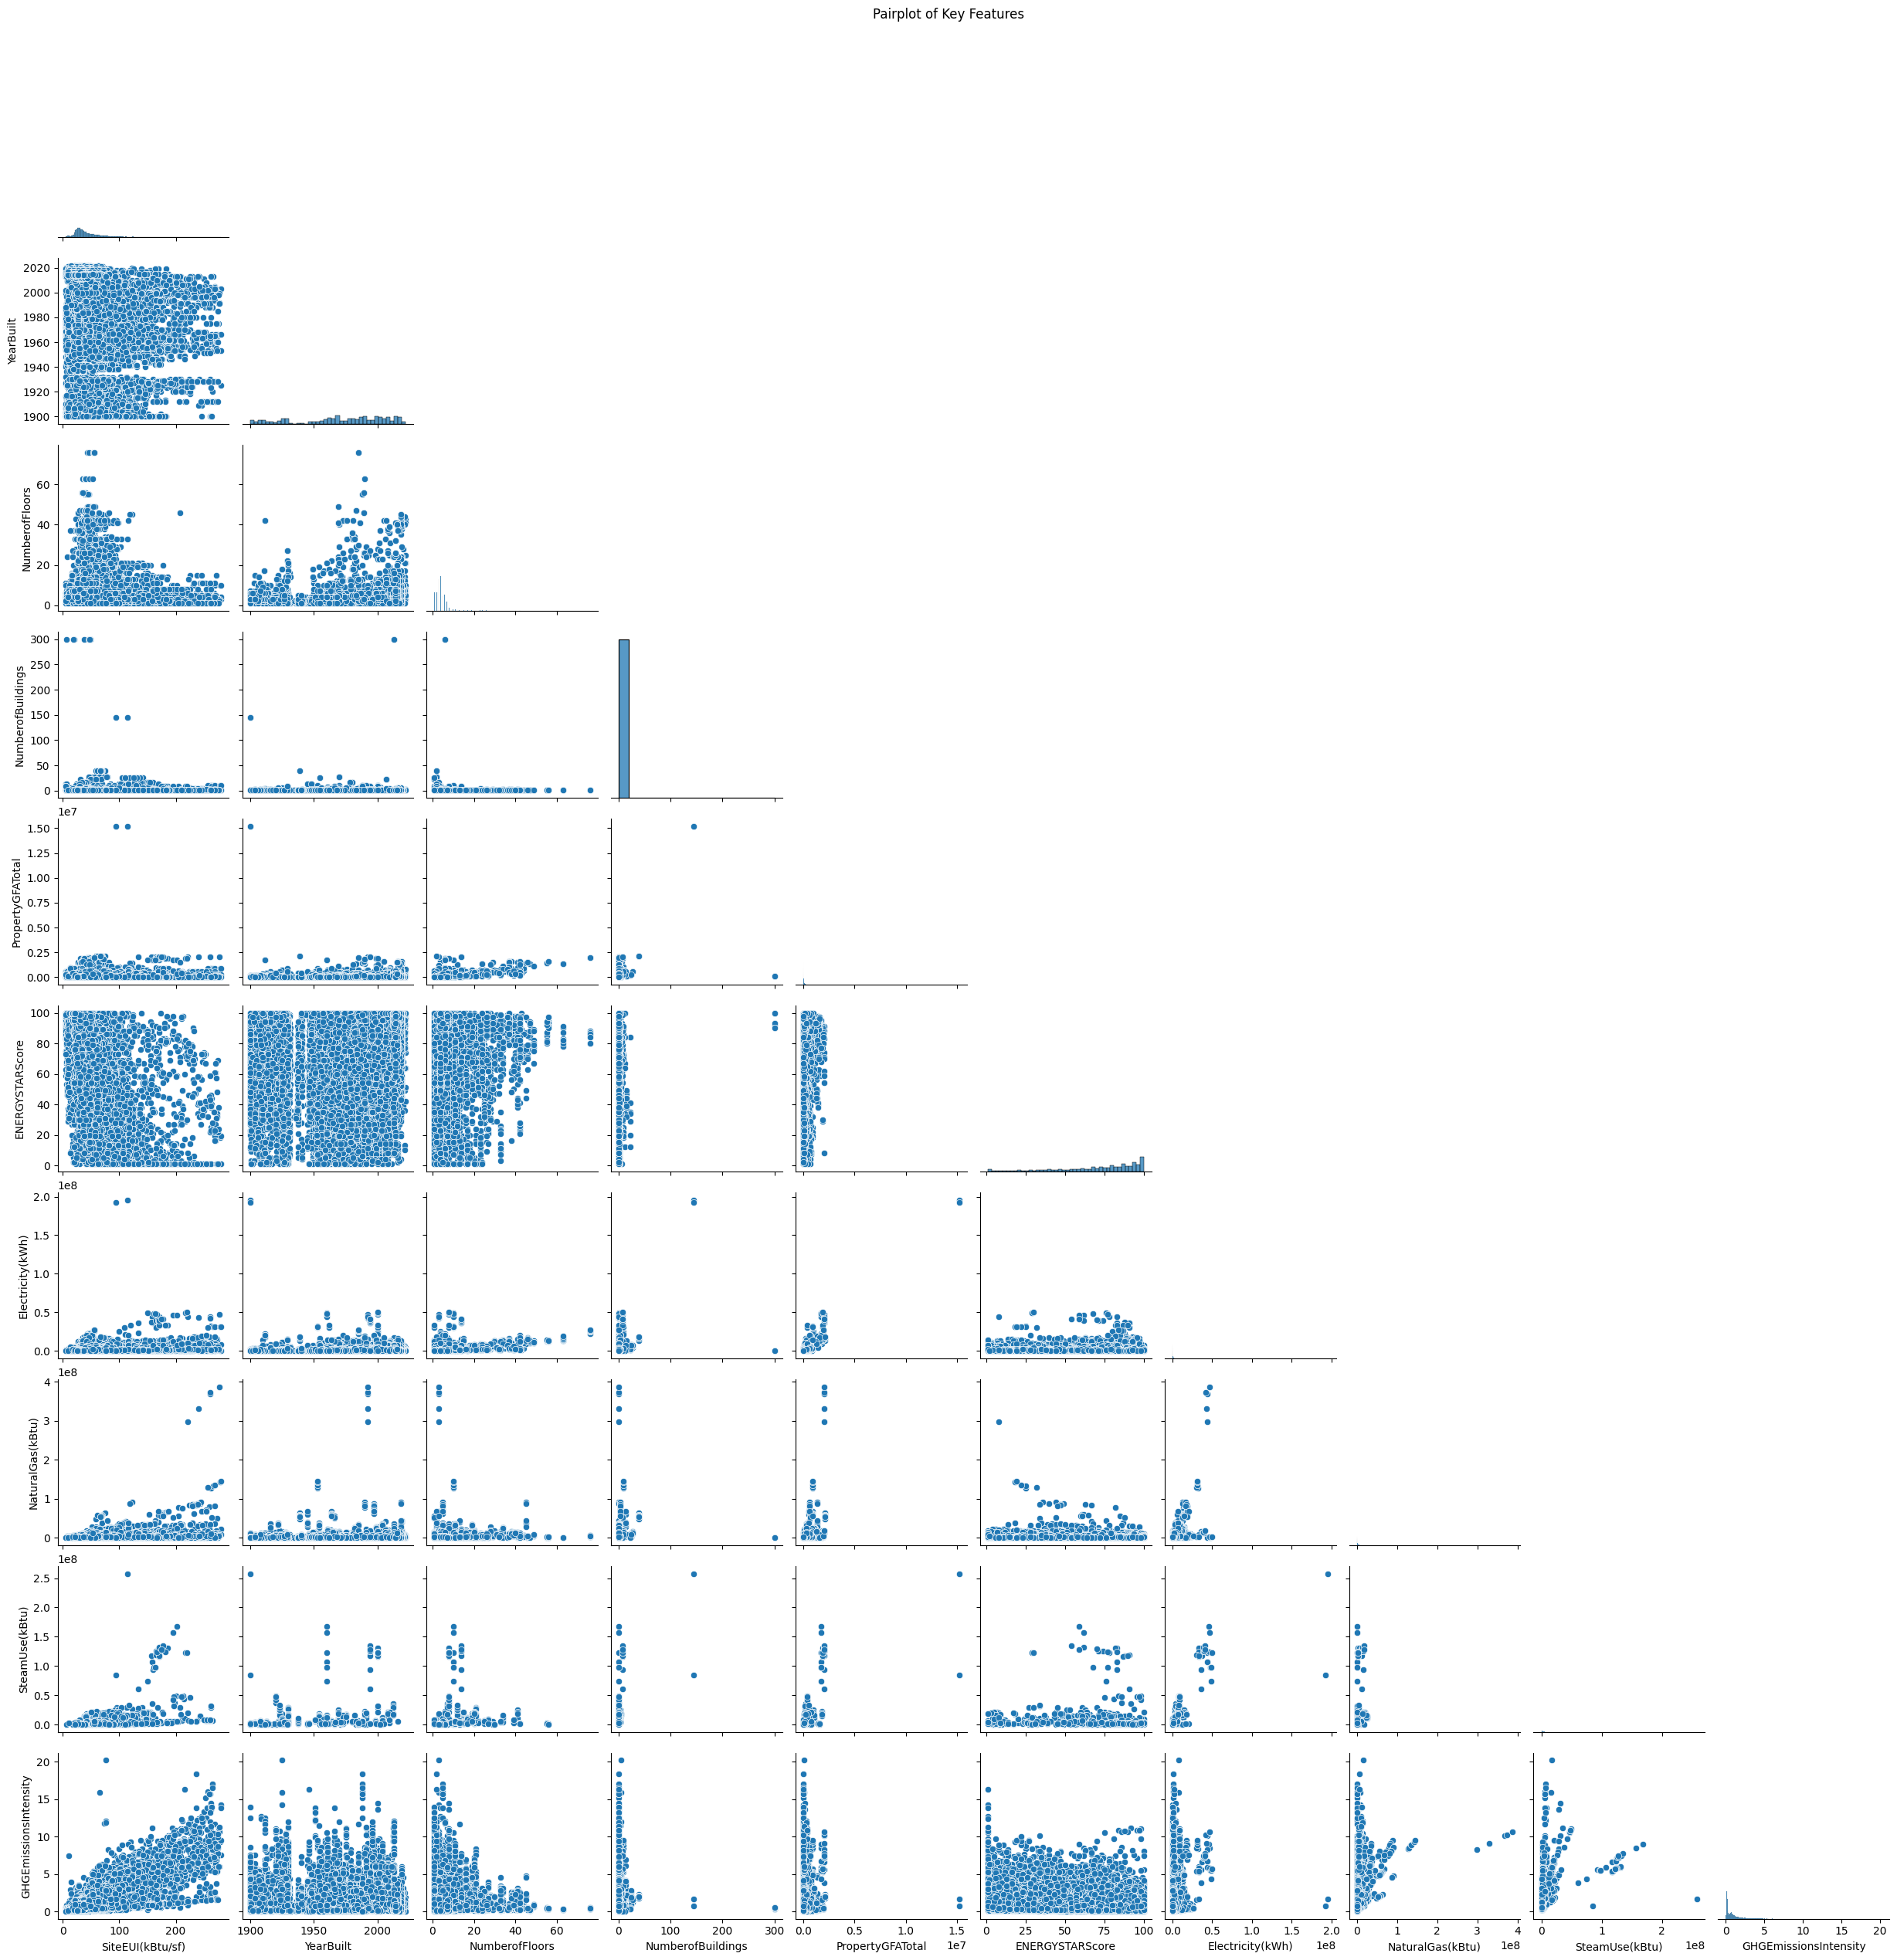

In [14]:
# ## 4. Pairplot (Scatter Matrix) for Selected Features

selected_features = [
    "SiteEUI(kBtu/sf)",
    "YearBuilt",
    "NumberofFloors",
    "NumberofBuildings",
    "PropertyGFATotal",
    "ENERGYSTARScore",
    "Electricity(kWh)",
    "NaturalGas(kBtu)",
    "SteamUse(kBtu)",
    "GHGEmissionsIntensity"
]

plt.figure(figsize=(12, 10))
sns.pairplot(df[selected_features], corner=True)
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()

In [15]:
# ## 5. Correlation Heatmap


corr_matrix = df[selected_features].corr().round(2)
z = corr_matrix.values
x = y = corr_matrix.columns.tolist()

fig_corr = ff.create_annotated_heatmap(
    z=z,
    x=x,
    y=y,
    annotation_text=corr_matrix.values.astype(str),
    colorscale="Viridis",
    showscale=True
)
fig_corr.update_layout(title="Correlation Matrix", height=700)
fig_corr.show()

In [16]:
# ## 6. Feature Engineering (for modeling)

features = [
    "DataYear", "YearBuilt", "NumberofFloors", "NumberofBuildings",
    "PropertyGFATotal", "ENERGYSTARScore",
    "Electricity(kWh)", "NaturalGas(kBtu)", "SteamUse(kBtu)",
    "GHGEmissionsIntensity"
]
categoricals = [
    "EPAPropertyType", "LargestPropertyUseType"
]

df = pd.get_dummies(df, columns=categoricals, drop_first=True)
model_features = features + [col for col in df.columns if col.startswith("EPAPropertyType_") or col.startswith("LargestPropertyUseType_")]

X = df[model_features]
y = df["SiteEUI(kBtu/sf)"]

print("Final input shape:", X.shape)

Final input shape: (29462, 142)
